<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/1-CNN/step1-train_vgg16_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune VGG16 CNN to Classify Gabor Tilts
### Adapted from [Tensorflow transfer learning tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).
--- 
## Import libraries

In [1]:
import tensorflow as tf
#from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np

Check tensorflow version

In [2]:
tf.__version__ 

'2.6.0'

### Load and prepare the data
The dataset is comprised of 18,000 total Gabors in two classes representing tilts from 45 degrees in the clockwise direction and tilts in the counterclockwise direction. The Gabors were generated in MATLAB using gen_gabor-range.m according to a range of 18 unique tilt/contrast combinations. 
- `tilts = [.1, .2, .4, .8, 1.6, 3.2]; # measured in degrees`
- `contrasts = [.3, .45, 1];  # measured in percent`  

500 Gabors were generated for each of the 18 groups for each of the 2 classes (500 x 18 x 2 = 18,000 total images). The dataset is divided into 11,988 training images, 4,788 validation images, and 1,224 testing images. The batch size is set at 32 and image size at 224 x 224 because the VGG model expects images of this size. 

We will download a zip file from OSF then extract its contents and change into the newly created directory: `content/model2_training/`

In [3]:
# @title Load data

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `Model 2 Training` dataset...")
name = 'model2_training'
fname = f"{name}.zip"
url = f"https://osf.io/u2pkt/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall(f"./{name}") #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

os.chdir(name) #move into extracted folder root
print("Download completed.")

Start downloading and unzipping `Model 2 Training` dataset...
Download completed.


In [8]:
def load_data():
    curr_dir = os.getcwd() 
    train_dir = os.path.join(curr_dir, 'train_range')
    validation_dir = os.path.join(curr_dir, 'validation_range')
    test_dir = os.path.join(curr_dir, 'test_range')
    BATCH_SIZE = 32 
    IMG_SIZE = (224, 224)
    IMG_SHAPE = IMG_SIZE + (3,) #adds a third dimension to hold 3 color channels
    train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE) 
    validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE) 
    test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE) 
    class_names = train_dataset.class_names #assign clockwise (clock) & counterclockwise (cclock) classes
    return BATCH_SIZE,IMG_SIZE,IMG_SHAPE,train_dataset,validation_dataset,test_dataset,class_names

BATCH_SIZE, IMG_SIZE, IMG_SHAPE, train_dataset, validation_dataset, test_dataset, class_names = load_data()

Found 11988 files belonging to 2 classes.
Found 4788 files belonging to 2 classes.
Found 1224 files belonging to 2 classes.


### Verify the data
To verify that the dataset looks correct, let's plot the first 9 images from the training set and display the class name above each image:

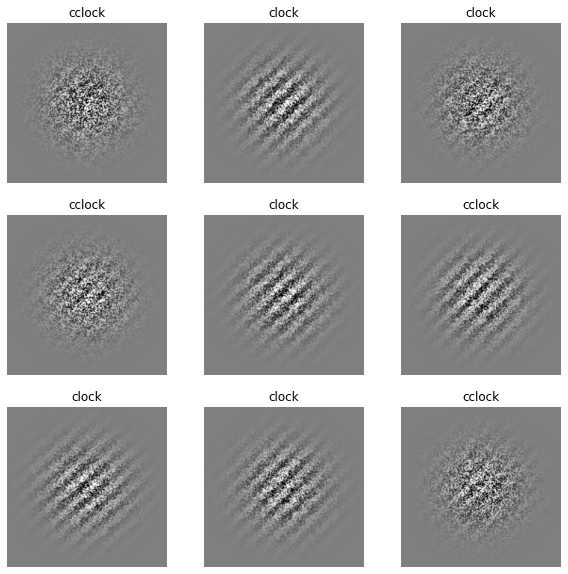

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): #load first iteration batch from training dataset
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) #setup axis on a 3x3 grid
    plt.imshow(images[i].numpy().astype("uint8"),cmap='gray') #plot each image
    plt.title(class_names[labels[i]]) #output associated label for chosen image
    plt.axis("off")

### Preprocess the data
Our images are RGB, but VGG16 expects images in BGR with each color channel zero-centered with respect to the ImageNet dataset, without scaling. We need to apply this transformation using the `preprocess_inputs` method.

In [10]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

### Setup buffered prefetching
We can configure the dataset for performance using buffered prefetching to load images from disk without having I/O become blocking

In [11]:
def prefetch(train_dataset, validation_dataset, test_dataset):
    AUTOTUNE = tf.data.AUTOTUNE #prompts the tf.data runtime to tune the value dynamically at runtime
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    return train_dataset,validation_dataset,test_dataset,AUTOTUNE

train_dataset, validation_dataset, test_dataset, AUTOTUNE = prefetch(train_dataset, validation_dataset, test_dataset)

### Create the base model

Next, we create the base model VGG16 with pre-loaded weights trained on ImageNet. The top classification layer will not be loaded so we can extract features to be used in our custom Gabor classifier layer.

In [12]:
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, 
                                               include_top=False,
                                               weights='imagenet') 

58900480/58889256 [==============================] - 1s 0us/step


This feature extractor converts each 224x224x3 image into a 7x7x512 block of features. Let's see what it does to an example batch of images:

In [13]:
image_batch, label_batch = next(iter(train_dataset)) #image_batch= (32,224,224,3), label_batch=(32,), 32 images
feature_batch = base_model(image_batch) 
print(feature_batch.shape) 

(32, 7, 7, 512)


We extracted features from one batch of images which resulted in a reduction in total overall dimensionality of the input images from [32,224,224,3] to [32,7,7,512]

STOPPED HERE. LINE 90 of MODEL.PY

Let's display the architecture of the model so far:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 158, 158, 160)     4480      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 79, 79, 160)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 77, 77, 80)        115280    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 80)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 36, 36, 40)        28840     
_________________________________________________________________
flatten_3 (Flatten)          (None, 51840)            

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 160 or 320). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

Finally, we see that (36, 36, 320) outputs were flattened into vectors of shape (414720) before going through two Dense layers.

### Compile and train the model

We will define the learning rate and use the BinaryCrossEntropy loss since the model provides a single linear output

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import os
from tensorflow.python.profiler import profiler_client

tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

  Timestamp: 14:37:26
  TPU type: TPU v2
  Utilization of TPU Matrix Units (higher is better): 0.000%




In [ ]:
base_learning_rate = 0.0001 #define the learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

history = model.fit(train_dataset, 
                    epochs=5, 
                    validation_data=validation_dataset) #tests against validation dataset after each iteration

Epoch 1/5
375/375 [==============================] - 75s 193ms/step - loss: 0.6756 - accuracy: 0.4993 - val_loss: 0.5634 - val_accuracy: 0.5000
Epoch 2/5
375/375 [==============================] - 72s 190ms/step - loss: 0.3835 - accuracy: 0.6639 - val_loss: 0.1978 - val_accuracy: 0.9171
Epoch 3/5
375/375 [==============================] - 72s 191ms/step - loss: 0.1805 - accuracy: 0.9142 - val_loss: 0.1720 - val_accuracy: 0.9121
Epoch 4/5
375/375 [==============================] - 72s 191ms/step - loss: 0.1573 - accuracy: 0.9257 - val_loss: 0.1659 - val_accuracy: 0.9348
Epoch 5/5
375/375 [==============================] - 72s 191ms/step - loss: 0.1389 - accuracy: 0.9344 - val_loss: 0.1440 - val_accuracy: 0.9363


### Evaluate the model
Let's make a plot to visualize how the training and validation accuracy improves with each epoch. We will also evaluate the model against the test dataset.

39/39 - 3s - loss: 0.1414 - accuracy: 0.9355


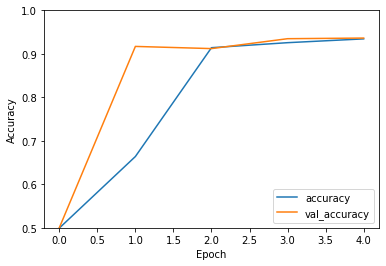

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

Nicely done! The model achieved a 93.63% accuracy on the validation set and a 93.55% accuracy on the test set after 5 epochs. Now let's save our vanilla CNN model.

In [ ]:
model.save('18kim_range_vanilla')

INFO:tensorflow:Assets written to: 18kim_range_vanilla/assets


In [ ]:
! zip -r vanilla_model.zip /content/model2_training/18kim_range_vanilla/

  adding: content/model2_training/18kim_range_vanilla/ (stored 0%)
  adding: content/model2_training/18kim_range_vanilla/assets/ (stored 0%)
  adding: content/model2_training/18kim_range_vanilla/saved_model.pb (deflated 89%)
  adding: content/model2_training/18kim_range_vanilla/keras_metadata.pb (deflated 91%)
  adding: content/model2_training/18kim_range_vanilla/variables/ (stored 0%)
  adding: content/model2_training/18kim_range_vanilla/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: content/model2_training/18kim_range_vanilla/variables/variables.index (deflated 66%)
